## Enhancing OCT image resolution with SRGANs


#### Keywords: unsupervised super-resolution, SRGAN-VGG19

## I. Introduction

Optical coherence tomography (OCT) scans of the retina are used to produce high resolution cross-sectional images of the retina. OCT imaging is the now the standard of care in opthalmology
and there is interest in applying AI methods to enhance conventional OCT images from commercial systems. 

The computational enhancement of image resolution, is known as *super-resolution*. Generative Adversarial Networks (GANs) <a href="#ref1">[1]</a> are one of newer methods that have been applied to super resolution and in this notebook we use a  Super-Resolution GAN (SRGAN) <a href="#ref2">[2]</a> to enhance subsampled OCT scans.

The SRGAN, introduced in 2016, addressed the issue of reconstructing high resolution (HR) images from low resolution (LR) images such that fine texture detail in the reconstructed super resolution (SR) images was not lost. Here the authors used a perceptual loss instead of a pixel-wise Mean Squared Error (MSE) loss. MSE loss approaches give a high Peak Signal-to-Noise (PSNR) value, but they also tend to produce overly-smooth images with insufficient high-frequency details. The perceptual loss by contrast has a content loss component that computes pixel-wise differences in feature space (not pixel space) and this results in an SR image that is closer to the subjective evaluation of human observers.

The SRGAN model uses a deep neural network (built with residual blocks) and optimized using perceptual loss in a GAN framework. A VGG-19 network is used for feature extraction; this allows us to compute the feature distance between the original and generated images sent through the feature extractor.

In this exercise we use an SRGAN design which is faithful to the original SRGAN <a href="#ref2">[2]</a>. This architecture used a pre-trained VGG-19 feature extractor and gave photorealistic results on large (4x) upsampled low resolution images. It has been applied to the DIV2K, CelebA and other natural image datasets and here we want to see how it performs on OCT data. This network will serve as a baseline for further experiments with upscaling, choice of feature extractor etcetera.

The SRGAN is implemented as follows:

**Training**
1. We downsample HR OCT images by 4x to synthetically create LR training data. This gives us pairs of HR and LR images for the training data set.
2. The Generator upsamples LR images by 4x and will be trained to generate SR images.
3. The discriminator will be trained to distinguish between HR/SR images; the GAN loss is backpropagated to the discriminator and the generator.

**Evaluation**  
The  visual quality of generated images will be observed. In addition standard quantitative metrics, Peak Signal-to-Noise Ratio and Structural Similarity Index (PSNR, SSIM), will be used to assess the results.

**Code**  
The code is based on the SRGAN  paper <a href="#ref2">[2]</a> and Kailash Ahirwar's code <a href="#ref3">[3]</a>.

## II. Imports and globals

In [1]:
# install an older version of tensorflow 
# (the implementation may not work with the most recent TensorFlow release)

!pip install keras==2.3.1
!pip install tensorflow==2.1.0

     |████████████████████████████████| 377 kB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 4.4 MB/s  eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 421.8 MB 19 kB/s s eta 0:00:01     |███████████████████▎            | 254.3 MB 60.0 MB/s eta 0:00:03     |███████████████████▌            | 257.0 MB 60.0 MB/s eta 0:00:03     |███████████████████▋            | 258.5 MB 60.0 MB/s eta 0:00:03     |███████████████████▊            | 259.8 MB 60.0 MB/s eta 0:00:03     |████████████████████            | 264.1 MB 60.0 MB/s eta 0:00:03     |████████████████████▏           | 265.6 MB 60.0 MB/s eta 0:00:03     |████████████████████▌           | 269.8 MB 60.0 MB/s eta 0:00:03     |██████████████████████▏         | 292.9 MB 38.3

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import glob
import os

from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam


import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)

Using TensorFlow backend.


Tensorflow version 2.1.0
Keras version 2.2.4-tf


In [4]:
# data path
TRAIN_PATH = r'/kaggle/input/generated-images-xray/'
VAL_PATH = r'/kaggle/input/generated-images-xray/'
TEST_PATH = r'/kaggle/input/generated-images-xray/'
data_path = TRAIN_PATH

epochs = 5

# batch size equals to 8 (due to RAM limits)
batch_size = 8

# define the shape of low resolution image (LR) 
low_resolution_shape = (32, 32, 3)

# define the shape of high resolution image (HR) 
high_resolution_shape = (256, 256, 3)

# optimizer for discriminator, generator 
common_optimizer = Adam(0.0002, 0.5)

# use seed for reproducible results
SEED = 2020 
tf.random.set_seed(SEED)

## III. Data

Load data, process data, EDA

In [5]:
def get_train_images(data_path):
    CLASSES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    CLASSES = ['COVID_1', 'Normal', 'Pneumonia']
    image_list = []
    
    for class_type in CLASSES:
        image_list.extend(glob.glob(data_path + class_type + '/*'))
    
    return image_list    

In [6]:
def find_img_dims(image_list):
    
    min_size = []
    max_size = []
    
    for i in range(len(image_list)):
        im = Image.open(image_list[i])
        min_size.append(min(im.size))
        max_size.append(max(im.size))
    
    return min(min_size), max(max_size)

In [7]:
# get min/max image sizes

image_list = get_train_images(data_path)
min_size, max_size = find_img_dims(image_list)
print('The min and max image dims are {} and {} respectively.'
      .format(min_size, max_size))

The min and max image dims are 256 and 256 respectively.


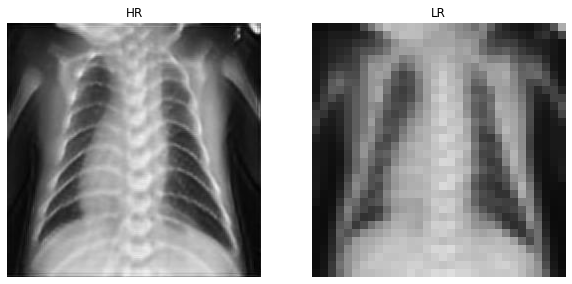

In [32]:
## Cek dataset sebelum dan setelah diproses pengurangan resolusi


image_list = get_train_images(data_path)
    
low_resolution_shape = (32, 32, 3)
high_resolution_shape = (256, 256, 3)

def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    

    for img in images_batch:
  
        img1 = imread(img, as_gray=False, pilmode='RGB')
        #img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # change the size     
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)    


hr_images, lr_images = sample_images(image_list, 
                                     batch_size=batch_size,
                                     low_resolution_shape=low_resolution_shape,
                                     high_resolution_shape=high_resolution_shape)

# normalize the images
hr_images = hr_images / 127.5 - 1.
lr_images = lr_images / 127.5 - 1.

    
fig, ax = plt.subplots(1,2, figsize=(10, 6))


for idx in range(len(hr_images)):
    
    titles = ['HR', 'LR']
    images = [hr_images[idx], lr_images[idx]]
    
    for i, img in enumerate(images):
        ax[i].imshow((img + 1)/2.0, cmap='gray')
        ax[i].axis("off")
        ax[i].set_title(titles[i])
        
plt.show()

## IV. Utility functions

Quantitative metrics for image quality  
Loss functions  
Plots  
Image processing: sampling and saving images

### IV A. Metrics

#### 1. PSNR - Peak Signal-to-Noise ratio


PSNR is the ratio between maximum possible power of signal and power of corrupting noise (Wikipedia). 


$${ PSNR = 10  \log_{10}  \left( {MAX_I^2 \over MSE} \right) }$$

$ MAX_I $  -  maximum possible power of a signal of image I  
$ MSE $  -  mean squared error pixel by pixel 

In [8]:
def compute_psnr(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    psnr = tf.image.psnr(original_image, generated_image, max_val=1.0)

    return tf.math.reduce_mean(psnr, axis=None, keepdims=False, name=None)

In [9]:
def plot_psnr(psnr):
    
    psnr_means = psnr['psnr_quality']
    plt.figure(figsize=(10,8))
    plt.plot(psnr_means)    
    plt.xlabel('Epochs')
    plt.ylabel('PSNR') 
    plt.title('PSNR')

#### 2. SSIM - Structural Similarity Index


SSIM measures the perceptual difference between two similar images [(see Wikipedia)](https://en.wikipedia.org/wiki/Structural_similarity).

$${ SSIM(x, y) = {(2 \mu_x \mu_y + c_1) (2 \sigma_{xy} + c_2) \over (\mu_x^2 + \mu_y^2 + c_1) ( \sigma_x^2 + \sigma_y^2 +c_2)}  }$$


$ \mu_x, \mu_y$       - average value for image $x, y$    
$ \sigma_x, \sigma_y$ - standard deviation for image $x, y$     
$ \sigma_{xy}$        - covariance  of $x$ and $y$      
$ c_1, c_2 $          - coefficients 

In [10]:
def compute_ssim(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    ssim = tf.image.ssim(original_image, generated_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

    return tf.math.reduce_mean(ssim, axis=None, keepdims=False, name=None)

In [11]:
def plot_ssim(ssim):
    
    ssim_means = ssim['ssim_quality']

    plt.figure(figsize=(10,8))
    plt.plot(ssim_means)
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.title('SSIM')

### IV B. Loss Functions

The most important contribution of the SRGAN paper was the use of a *perceptual loss* function. 


**Perceptual Loss**  is a weighted sum of the *content loss* and *adversarial loss*.


$${ l^{SR} = l_X^{SR} + 10^{-3}l_{Gen}^{SR}}$$

$l^{SR}$ - perceptual loss   
$l_X^{SR}$ - content loss   
$l_{Gen}^{SR}$ - adversarial loss 


****************************

**1. Content Loss**   
The SRGAN replaced the *MSE loss* with a *VGG loss*. Both losses are defined below: 

         
**Pixel-wise MSE loss** is the mean squared error between each pixel in the original HR image and a the corresponding pixel in the generated SR image.


**VGG loss** is the euclidean distance between the feature maps of the generated SR image and the original HR  image. The feature maps are the activation layers of the pre-trained  VGG 19 network. 

$${ l_{{VGG}/{i,j}}^{SR} = {1 \over {W_{i,j}H_{i,j}}} \sum\limits_{x=1}^{W_{i,j}} \sum\limits_{y=1}^{H_{i,j}}  ({\phi}_{i,j}(I^{HR})_{x,y} - {\phi}_{i,j} (G_{{\theta}_G} (I^{LR}))_{x,y})^2}$$


$ l_{{VGG}/{i,j}}^{SR} $  -  VGG loss    
$ {\phi}_{i,j} $  -   the feature map obtained by the j-th convolution (after activation) before the i-th maxpooling layer within the VGG19 network



**2. Adversarial Loss**  
This is calculated based on probabilities provided by Discriminator.

$${ l_{Gen}^{SR} = \sum\limits_{n=1}^{N} - \log{D_{{\theta}_D}} (G_{{\theta}_G} (I^{LR}))}$$

$ l_{Gen}^{SR} $  -  generative loss  
$ D $  -  discriminator function    
$ D_{{\theta}_D} $  -  discriminator function parametrized with $ {\theta}_D $   
$ {D_{{\theta}_D}} (G_{{\theta}_G} (I^{LR})) $   -  probability that the reconstructed image $ 
$ G_{{\theta}_G} (I^{LR}) $  is a natural HR image

#### Plot loss function

In [12]:
def plot_loss(losses):

    d_loss = losses['d_history']
    g_loss = losses['g_history']
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss")    
    plt.legend()

### IV C. Sampling, saving images

In [13]:
def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    

    for img in images_batch:
  
        img1 = imread(img, as_gray=False, pilmode='RGB')
        #img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # change the size     
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)    

In [35]:
def save_images(original_image, lr_image, sr_image, path):
    
    """
    Save LR, HR (original) and generated SR
    images in one panel 
    """
    
    fig, ax = plt.subplots(1,3, figsize=(10, 6))

    images = [original_image, lr_image, sr_image]
    titles = ['HR', 'LR','SR - generated']

    for idx,img in enumerate(images):
        # (X + 1)/2 to scale back from [-1,1] to [0,1]
        ax[idx].imshow((img + 1)/2.0, cmap='gray')
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
        
    plt.savefig(path)    

## V. SRGAN-VGG19

The SRGAN has the following code components:
 1. Generator network
 2.  Discriminator network
 3. Feature extractor using the VGG19 network
 4. Adversarial framework

### V 1. Generator

There are 16 residual blocks and 2 upsampling blocks. The generator follows the architecture outlined in [2]. 

In [36]:
def residual_block(x):

    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    
    return res

In [16]:
def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (64, 64, 3)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # conv layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model

generator = build_generator()

In [17]:
generator = build_generator()

In [45]:
def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (32, 32, 3)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # add a 1x1 conv layer to match shapes before the addition operation
    gen1_resize = Conv2D(filters=64, kernel_size=1, strides=1, padding='same')(gen1)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1_resize])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # upsampling
    gen6 = UpSampling2D(size=2)(gen5)
    gen6 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen6)
    gen6 = Activation('relu')(gen6)
    
    # conv layer at the output
    gen7 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen6)
    output = Activation('tanh')(gen7)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model

generator = build_generator()
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 32, 32, 64)   15616       input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 32, 32, 64)   36928       conv2d_167[0][0]                 
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 32, 32, 64)   0           conv2d_168[0][0]                 
__________________________________________________________________________________________

### V 2. Discriminator

In [38]:
def build_discriminator():
    
    # define hyperparameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    
    # the input is the HR shape
    input_shape = (256, 256, 3)
    
    # input layer for discriminator
    input_layer = Input(shape=input_shape)
    
    # 8 convolutional layers with batch normalization  
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    
    # fully connected layer 
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    
    # last fully connected layer - for classification 
    output = Dense(units=1, activation='sigmoid')(dis9)
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    
    return model

In [39]:
discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

### V 3. VGG19 Feature Extractor 

In [20]:
VGG19_base = VGG19(weights="imagenet")

574717952/574710816 [==============================] - 4s 0us/step


In [21]:
def build_VGG19():
    
    input_shape = (256, 256, 3)
    VGG19_base.outputs = [VGG19_base.get_layer('block5_conv2').output]
    input_layer = Input(shape=input_shape)
    features = VGG19_base(input_layer)
    model = Model(inputs=[input_layer], outputs=[features])
    
    return model

In [22]:
fe_model = build_VGG19()
fe_model.trainable = False
fe_model.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [46]:
def build_adversarial_model(generator, discriminator, feature_extractor):
    
    # input layer for high-resolution images
    input_high_resolution = Input(shape=high_resolution_shape)

    # input layer for low-resolution images
    input_low_resolution = Input(shape=low_resolution_shape)

    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator(input_low_resolution)

    # extract feature maps from generated images
    features = feature_extractor(generated_high_resolution_images)
    
    # make a discriminator non-trainable 
    discriminator.trainable = False
    discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # discriminator will give us a probability estimation for the generated high-resolution images
    probs = discriminator(generated_high_resolution_images)

    # create and compile 
    adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
    adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)
    
    return adversarial_model


In [47]:
adversarial_model = build_adversarial_model(generator, discriminator, fe_model)

## VI. Training 


In [48]:
# initialize 

losses = {"d_history":[], "g_history":[]}
psnr = {'psnr_quality': []}
ssim = {'ssim_quality': []}

Epoch ke 1  PSNR 2.9886603355407715  SSIM -0.00885813683271408
Epoch ke 2  PSNR 3.5822300910949707  SSIM 0.017129505053162575
Epoch ke 3  PSNR 3.3228492736816406  SSIM 0.022540709003806114
Epoch ke 4  PSNR 4.039323806762695  SSIM 0.028201526030898094
Epoch ke 5  PSNR 4.412956237792969  SSIM 0.032800737768411636
Epoch ke 6  PSNR 3.51896595954895  SSIM 0.0111461840569973
Epoch ke 7  PSNR 4.066899299621582  SSIM 0.03458891063928604
Epoch ke 8  PSNR 3.8223187923431396  SSIM 0.023209385573863983
Epoch ke 9  PSNR 3.301628589630127  SSIM 0.011555153876543045
Epoch ke 10  PSNR 3.9854485988616943  SSIM 0.012881497852504253
Epoch ke 11  PSNR 4.072775840759277  SSIM 0.0351681187748909
Epoch ke 12  PSNR 4.136374473571777  SSIM 0.03660377860069275
Epoch ke 13  PSNR 3.0281357765197754  SSIM 0.00614720955491066
Epoch ke 14  PSNR 4.012814521789551  SSIM 0.03816818818449974
Epoch ke 15  PSNR 3.6342453956604004  SSIM 0.03581845015287399
Epoch ke 16  PSNR 3.4438247680664062  SSIM 0.025243142619729042
Epo

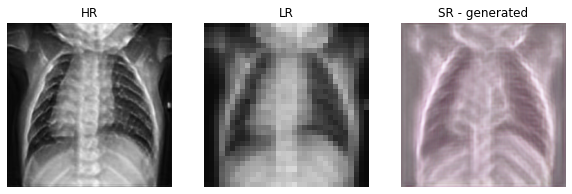

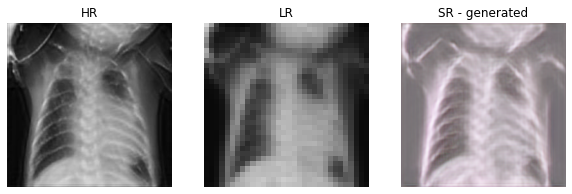

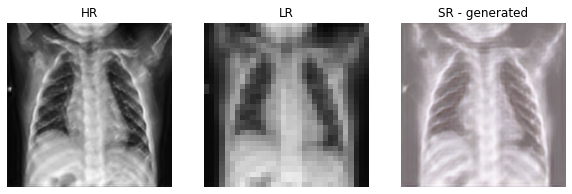

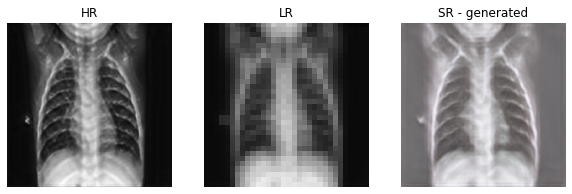

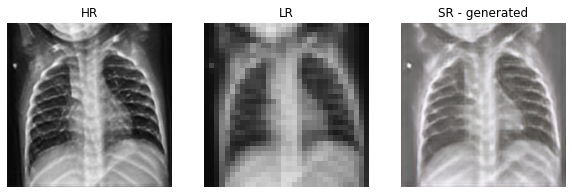

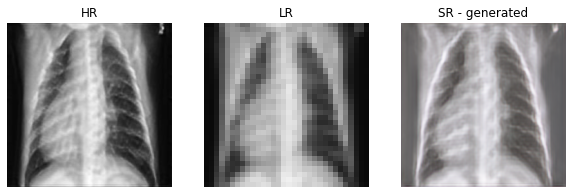

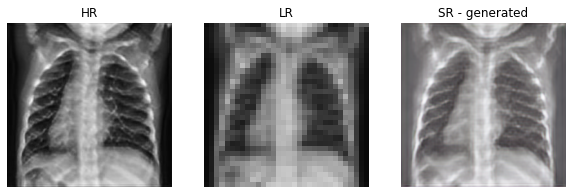

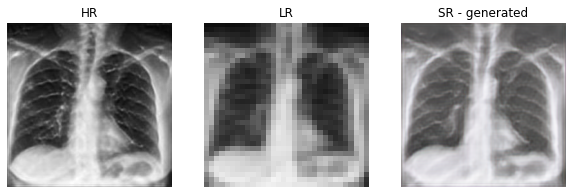

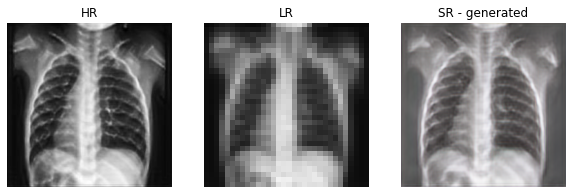

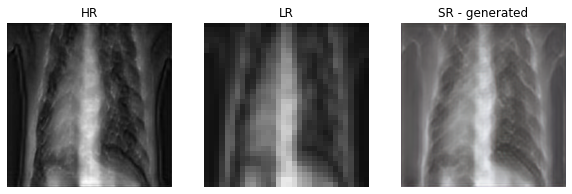

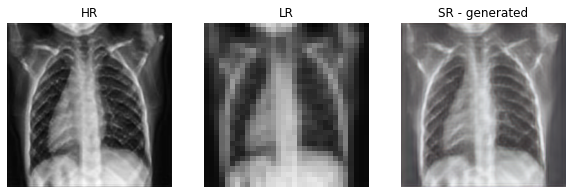

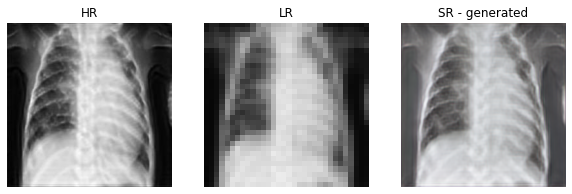

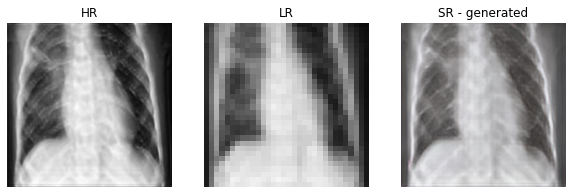

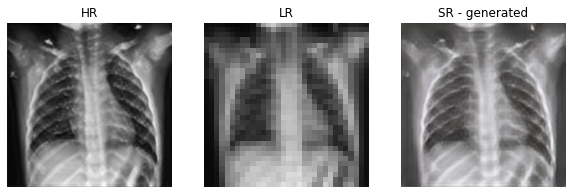

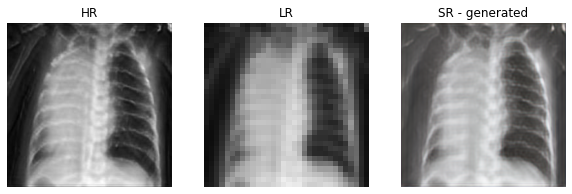

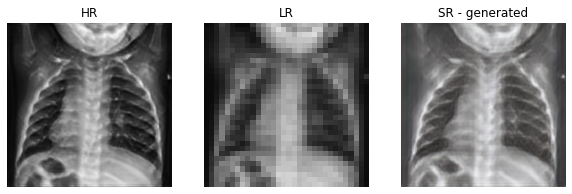

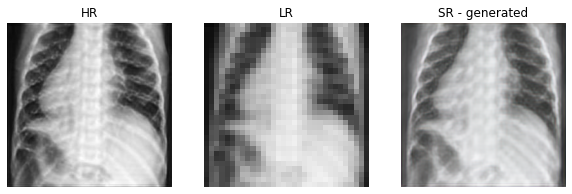

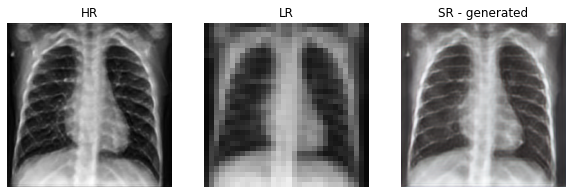

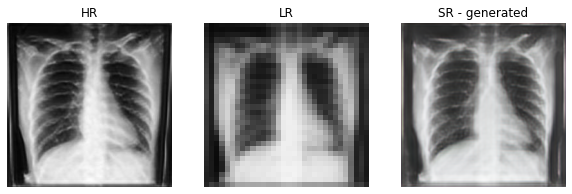

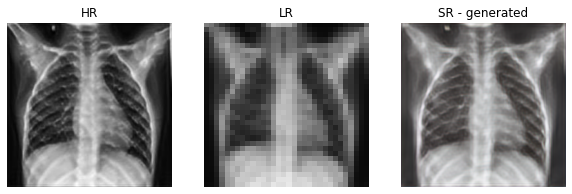

In [53]:
# training loop

for epoch in range(1000):

    d_history = []
    g_history = []
    
    image_list = get_train_images(data_path)
    
    """
    Train the discriminator network
    """
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator.predict(lr_images)
    
    # generate a batch of true and fake labels 
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    
 
    d_loss_real = discriminator.train_on_batch(hr_images, real_labels)
    d_loss_real =  np.mean(d_loss_real)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss_fake =  np.mean(d_loss_fake)
    
    # calculate total loss of discriminator as average loss on true and fake labels
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    losses['d_history'].append(d_loss)
   

    """
        Train the generator network
    """
      
    # sample a batch of images    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # extract feature maps for true high-resolution images
    image_features = fe_model.predict(hr_images)

    # train the generator
    g_loss = adversarial_model.train_on_batch([lr_images, hr_images], [real_labels, image_features])
    losses['g_history'].append(0.5 * (g_loss[1]))

    # calculate the psnr  
    ps = compute_psnr(hr_images, generated_high_resolution_images) 
    psnr['psnr_quality'].append(ps)
            
    # calculate the ssim 
    ss = compute_ssim(hr_images, generated_high_resolution_images)   
    ssim['ssim_quality'].append(ss)
    
    data_ke = epoch + 1    
    print("Epoch ke {}  PSNR {}  SSIM {}".format(data_ke, ps.numpy(), ss.numpy()))

    
    
    """
        save and print image samples
    """
    if epoch % 50 == 0:
        
        hr_images, lr_images = sample_images(image_list, 
                                             batch_size=batch_size,
                                             low_resolution_shape=low_resolution_shape,
                                             high_resolution_shape=high_resolution_shape)
    
    
        # normalize the images
        hr_images = hr_images / 127.5 - 1.
        lr_images = lr_images / 127.5 - 1.
    
    
        generated_images = generator.predict_on_batch(lr_images)
    
        for index, img in enumerate(generated_images):
            if index < 1:   # comment this line to display all the images
                save_images(hr_images[index], lr_images[index], img,
                            path="/kaggle/working/img_{}_{}".format(epoch, index))  

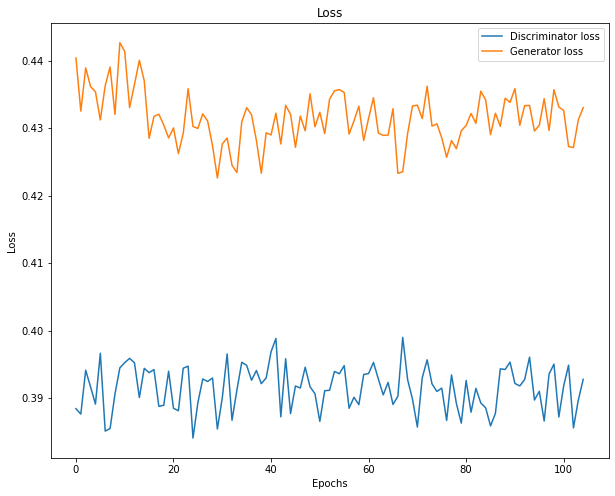

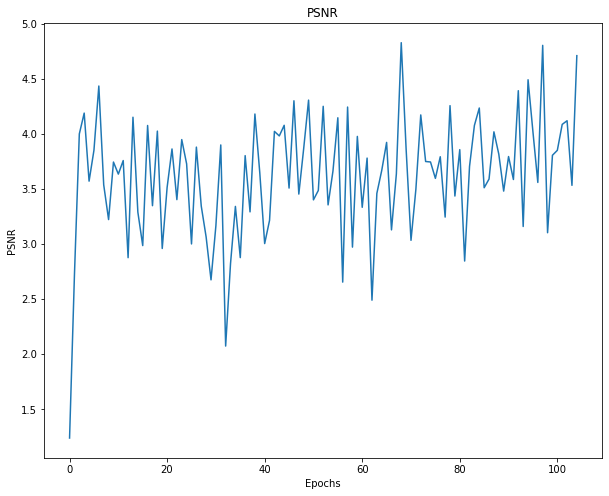

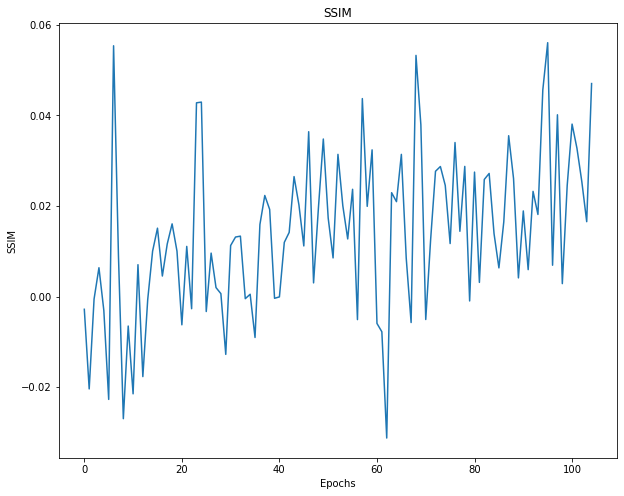

In [52]:
# plots - post training
plot_loss(losses)
plot_psnr(psnr)
plot_ssim(ssim)

In [ ]:
# save model weights
generator.save_weights("/kaggle/working/srgan_generator.h5")
discriminator.save_weights("/kaggle/working/srgan_discriminator.h5")

## VII. References and further reading


<a name="ref1"></a>[1] [Goodfellow et al. 'Generative Adversarial Nets'](https://arxiv.org/pdf/1406.2661.pdf)

<a name="ref2"></a>[2] [Ledig et al. 'Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network'](https://arxiv.org/abs/1609.04802)

<a name="ref3"></a>[3] [Kailash Ahirwar. 'Generative Adversarial Networks Projects'](https://github.com/PacktPublishing/Generative-Adversarial-Networks-Projects)

<a name="ref4"></a>[4] [Saeed Anwar et al. 'A Deep Journey into Super-resolution: A Survey'](https://arxiv.org/pdf/1904.07523.pdf)

<a name="ref5"></a>[5] [Xintao Wang et al. 'ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks'](https://arxiv.org/pdf/1809.00219.pdf)